The questions answered in this notebook are as follows:
<ul>
    <li>Is there a bias towards either the favourite or the underdog?
    <li>Does how volatile a game is change how we should  be betting?


Import packages

In [1]:
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import comb

Load data into a pandas dataframe

In [2]:
### Loop the data lines
with open("completed.csv", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
df = pd.read_csv("completed.csv", header=None, delimiter=",", names=column_names)

print(df.shape)

df.head()

(118, 226)


,0,1,2,3,4,5,6,7,8,9,...,216,217,218,219,220,221,222,223,224,225
0,Infamous,4FUN,18.50,1.34,22.00,1.36,34.00,1.32,34.00,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4 Zoomers,Quincy Crew,7.48,1.51,7.48,1.51,7.48,1.51,7.48,1.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EHOME,Invictus,1.23,3.92,1.23,3.92,1.22,4.04,1.22,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sparking Arrow,ViCi,6.02,1.11,6.02,1.11,6.08,1.10,6.08,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Invictus,PSG.LGD,5.43,1.12,5.43,1.12,5.43,1.12,5.43,1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets see how the odds changed through out each game, we'll call this deviation.

In [3]:
def deviation(row):
    #Cycle through the row noting any change in odds
    i = 4
    left_odds = row[2]
    right_odds = row[3]
    total_change = 0
    while i < df.shape[1]-2:
        if row[i] == -1: #-1 is given if no odds were available
            break
        if left_odds == row[i] and right_odds == row[i+1]:
            pass
        else:
            total_change += math.log(1 + abs(left_odds - row[i]) + abs(right_odds - row[i+1])) 
        i+=2
        #We take the log of the above to account for small changes making a large difference in the odds at the extremes
            
    return total_change

df['deviation'] = df.apply(deviation, axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,deviation
0,Infamous,4FUN,18.50,1.34,22.00,1.36,34.00,1.32,34.00,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.358801
1,4 Zoomers,Quincy Crew,7.48,1.51,7.48,1.51,7.48,1.51,7.48,1.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.204710
2,EHOME,Invictus,1.23,3.92,1.23,3.92,1.22,4.04,1.22,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.948360
3,Sparking Arrow,ViCi,6.02,1.11,6.02,1.11,6.08,1.10,6.08,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600569
4,Invictus,PSG.LGD,5.43,1.12,5.43,1.12,5.43,1.12,5.43,1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.889453


We can't tell anything about the games where the odds were locked i.e deviation = 0. So lets ignore those.

In [4]:
df = df[df['deviation'] > 0]

Find the number of times the predicted winner changed to the opposite team. This is a very useful stat when considering who won and who the favourite/underdog is.

In [5]:
def find_changes(row):
    #Define variables to track the changes of th winning team
    number_of_changes = -1
    winning = -1        
    
    #Loop through the row noting when a change occurs
    i = 2
    while i < df.shape[1]-2:
        if row[i] == -1: #-1 is given if no odds were available
            break
        else:
            if row[i] > row[i+1]:
                if winning != 0:
                    number_of_changes += 1
                winning = 0
            else:
                if winning != 1:
                    number_of_changes += 1
                winning = 1
        i+=2
                
    return number_of_changes

#Apply the above function to each row whilst adding the result to a new column
df['winner_change'] = df.apply(find_changes, axis=1)

df

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,deviation,winner_change
0,Infamous,4FUN,18.50,1.34,22.00,1.36,34.00,1.32,34.00,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.358801,0
1,4 Zoomers,Quincy Crew,7.48,1.51,7.48,1.51,7.48,1.51,7.48,1.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.204710,3
2,EHOME,Invictus,1.23,3.92,1.23,3.92,1.22,4.04,1.22,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.948360,0
3,Sparking Arrow,ViCi,6.02,1.11,6.02,1.11,6.08,1.10,6.08,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600569,0
4,Invictus,PSG.LGD,5.43,1.12,5.43,1.12,5.43,1.12,5.43,1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.889453,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Quincy Crew,Infamous,1.51,7.48,1.51,7.48,1.51,7.48,1.51,7.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.283777,3
112,Aster,EHOME,1.64,2.17,1.61,2.23,1.61,2.23,1.61,2.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.369590,1
113,PSG.LGD,EHOME,1.43,2.70,1.50,2.49,1.47,2.57,1.47,2.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.602223,0
116,Empire,Yellow Submarine,5.18,1.13,5.52,1.12,6.33,1.10,6.04,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.440245,0


Knowing who won is also useful.

In [6]:
#This seems like I've done it in a complicated way but I save having to loop through the row
def who_won(row):
    winner = row['winner_change']
    if row[2]*pow(-1,winner) > row[3]*pow(-1,winner): #odd 'winner_change' number will swap who was winning to begin with
        return 1
    elif row[2]*pow(-1,winner) < row[3]*pow(-1,winner):
        return 0
    else:
        return 2 #return 2 if equal or an error has occurred

df['winner'] = df.apply(who_won, axis=1)

df

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,deviation,winner_change,winner
0,Infamous,4FUN,18.50,1.34,22.00,1.36,34.00,1.32,34.00,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.358801,0,1
1,4 Zoomers,Quincy Crew,7.48,1.51,7.48,1.51,7.48,1.51,7.48,1.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.204710,3,0
2,EHOME,Invictus,1.23,3.92,1.23,3.92,1.22,4.04,1.22,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.948360,0,0
3,Sparking Arrow,ViCi,6.02,1.11,6.02,1.11,6.08,1.10,6.08,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600569,0,1
4,Invictus,PSG.LGD,5.43,1.12,5.43,1.12,5.43,1.12,5.43,1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.889453,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Quincy Crew,Infamous,1.51,7.48,1.51,7.48,1.51,7.48,1.51,7.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.283777,3,1
112,Aster,EHOME,1.64,2.17,1.61,2.23,1.61,2.23,1.61,2.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.369590,1,1
113,PSG.LGD,EHOME,1.43,2.70,1.50,2.49,1.47,2.57,1.47,2.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.602223,0,0
116,Empire,Yellow Submarine,5.18,1.13,5.52,1.12,6.33,1.10,6.04,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.440245,0,1


In [7]:
#Count the times the favourite won and the underdog won
def count_winner(winner_change_series):
    favourite_wins = 0
    underdog_wins = 0
    for row in winner_change_series:
        if row%2 == 0:
            favourite_wins += 1
        else:
            underdog_wins += 1
    return (favourite_wins, underdog_wins)

favourite_underdog = count_winner(df['winner_change'])

#Display the result as a percentage of the total games
def percent(a,b):
    c = a+b
    return (a/c, b/c)

results = percent(favourite_underdog[0], favourite_underdog[1])

print('The favourites won {} of their games whilst the underdogs won {} of their games.'.format(results[0], results[1]))


The favourites won 0.6666666666666666 of their games whilst the underdogs won 0.3333333333333333 of their games.


Now we'll compare the above to the expected results.

In [8]:
#Get the average favourite/underdog odds
def count_favourite_underdog(initial_odds):
    favourite_count = 0
    underdog_count = 0
    for one, two in zip(initial_odds[2], initial_odds[3]):
        favourite_count += min(one,two)
        underdog_count += max(one, two)
    
    #get the averages
    favourite_count = favourite_count/initial_odds.shape[0]
    underdog_count = underdog_count/initial_odds.shape[0]
    
    #convert the odds to a win percentage
    favourite_count = 1/favourite_count
    underdog_count = 1/underdog_count
    
    #split the difference to account for the bookies edge and add to the win percentages
    difference = (1 - (favourite_count + underdog_count))/2
    favourite_count += difference
    underdog_count += difference
    
    return favourite_count, underdog_count

count_favourite_underdog(df.iloc[:, 2:4])

(0.7125430460857917, 0.28745695391420834)

Although this seems like a bias for the underdog, the very unlikely teams who don't win might be swaying the average by a lot but not contributing to the winnings. The best way to truly test this is to bet on each underdog and see if money is made, we'll do the same for the favourites as well.

In [9]:
#Let's make a column that says who the favourite is:
def find_winner(row):
    if row[2] > row[3]:
        return 1
    elif row[3] > row[2]:
        return 0
    else:
        return 2

df['favourite'] = df.apply(find_winner, axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,deviation,winner_change,winner,favourite
0,Infamous,4FUN,18.50,1.34,22.00,1.36,34.00,1.32,34.00,1.32,...,NaN,NaN,NaN,NaN,NaN,NaN,32.358801,0,1,1
1,4 Zoomers,Quincy Crew,7.48,1.51,7.48,1.51,7.48,1.51,7.48,1.51,...,NaN,NaN,NaN,NaN,NaN,NaN,55.204710,3,0,1
2,EHOME,Invictus,1.23,3.92,1.23,3.92,1.22,4.04,1.22,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,30.948360,0,0,0
3,Sparking Arrow,ViCi,6.02,1.11,6.02,1.11,6.08,1.10,6.08,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,3.600569,0,1,1
4,Invictus,PSG.LGD,5.43,1.12,5.43,1.12,5.43,1.12,5.43,1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,92.889453,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Quincy Crew,Infamous,1.51,7.48,1.51,7.48,1.51,7.48,1.51,7.48,...,NaN,NaN,NaN,NaN,NaN,NaN,69.283777,3,1,0
112,Aster,EHOME,1.64,2.17,1.61,2.23,1.61,2.23,1.61,2.23,...,NaN,NaN,NaN,NaN,NaN,NaN,59.369590,1,1,0
113,PSG.LGD,EHOME,1.43,2.70,1.50,2.49,1.47,2.57,1.47,2.57,...,NaN,NaN,NaN,NaN,NaN,NaN,83.602223,0,0,0
116,Empire,Yellow Submarine,5.18,1.13,5.52,1.12,6.33,1.10,6.04,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,96.440245,0,1,1


In [10]:
#Let' bet on the underdog
def bet_on_underdog(row):
    if row['favourite'] == 2: #There was no favourite
        return 1
    if row['winner_change']%2 == 0:
        return -1
    else:
        return row[(3-row['favourite'])] - 1

def bet_on_favourite(row):
    if row['favourite'] == 2: #There was no favourite
        return 1
    if row['winner_change']%2 == 1:
        return -1
    else:
        return row[(2+row['favourite'])] - 1
    
df['bet_underdog'] = df.apply(bet_on_underdog, axis=1)    
df['bet_favourite'] = df.apply(bet_on_favourite, axis=1)

print('Betting on the underdogs would give a retun of ' + str(df['bet_underdog'].sum()/df.shape[0]) + ' per bet.')
print('Betting on the favourites would give a retun of ' + str(df['bet_favourite'].sum()/df.shape[0]) + ' per bet.')

Betting on the underdogs would give a retun of 0.4418181818181818 per bet.
Betting on the favourites would give a retun of 0.0017171717171717343 per bet.


There were some games where a draw was possible (a best of 2), these will all be giving good odds for both teams and raising the returns. Also a draw might have occured which we cannot know since the betting website still gives odds for the team who lost the first map (and therefore cannot win the series). We can find games where a draw was possible quite easily by finding odds that are 'too good' i.e hedgeable

In [11]:
def is_not_hedgeable(row):
    #winnings (row[2] - 1) from £1 bet on left team will make more than 1+winnings (row[2]) on the right team
    if (row[2]-1) * row[3] > row[2]:
        return False
    else:
        return True

non_draw_games=df[df.apply(is_not_hedgeable, axis=1)]
non_draw_games

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,deviation,winner_change,winner,favourite,bet_underdog,bet_favourite
2,EHOME,Invictus,1.23,3.92,1.23,3.92,1.22,4.04,1.22,4.04,...,NaN,NaN,NaN,NaN,30.948360,0,0,0,-1.00,0.23
3,Sparking Arrow,ViCi,6.02,1.11,6.02,1.11,6.08,1.10,6.08,1.10,...,NaN,NaN,NaN,NaN,3.600569,0,1,1,-1.00,0.11
4,Invictus,PSG.LGD,5.43,1.12,5.43,1.12,5.43,1.12,5.43,1.12,...,NaN,NaN,NaN,NaN,92.889453,0,1,1,-1.00,0.12
5,Live to Win,Yellow Submarine,1.97,1.78,1.97,1.78,1.97,1.78,2.04,1.71,...,NaN,NaN,NaN,NaN,25.222035,0,1,1,-1.00,0.78
6,Royal Never Give Up,Aster,1.58,2.29,3.70,1.25,3.70,1.25,3.70,1.25,...,NaN,NaN,NaN,NaN,25.659271,1,1,0,1.29,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Gambit,Live to Win,1.93,1.78,2.09,1.66,1.93,1.78,2.27,1.56,...,NaN,NaN,NaN,NaN,56.751904,0,1,1,-1.00,0.78
112,Aster,EHOME,1.64,2.17,1.61,2.23,1.61,2.23,1.61,2.23,...,NaN,NaN,NaN,NaN,59.369590,1,1,0,1.17,-1.00
113,PSG.LGD,EHOME,1.43,2.70,1.50,2.49,1.47,2.57,1.47,2.57,...,NaN,NaN,NaN,NaN,83.602223,0,0,0,-1.00,0.43
116,Empire,Yellow Submarine,5.18,1.13,5.52,1.12,6.33,1.10,6.04,1.10,...,NaN,NaN,NaN,NaN,96.440245,0,1,1,-1.00,0.13


Checking the profits on just this set.

In [12]:
non_draw_games['bet_underdog'] = non_draw_games.apply(bet_on_underdog, axis=1)    
non_draw_games['bet_favourite'] = non_draw_games.apply(bet_on_favourite, axis=1)

underdog_bet_return = non_draw_games['bet_underdog'].sum()/non_draw_games.shape[0]

print('Betting on the underdogs would give a retun of ' + str(underdog_bet_return) + ' per bet.')
print('Betting on the favourites would give a retun of ' + str(non_draw_games['bet_favourite'].sum()/non_draw_games.shape[0]) + ' per bet.')

Betting on the underdogs would give a retun of 0.09472972972972975 per bet.
Betting on the favourites would give a retun of -0.032162162162162146 per bet.


<ipython-input-12-c316fef653ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_draw_games['bet_underdog'] = non_draw_games.apply(bet_on_underdog, axis=1)
<ipython-input-12-c316fef653ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_draw_games['bet_favourite'] = non_draw_games.apply(bet_on_favourite, axis=1)


We can perform a p-test on this result i.e find the chances of a return of at least this high. This will give us a measure of how likely this is to occur by chance with no bias. To check the likelyhood of an outcome I'll use the binomial distribution with the average odds and win percentages which makes the estimate less accurate but to be exact means to check 2^(number of games) outcomes which is not doable.

In [13]:
#Find the average odds for the winner and loser
no_of_games = non_draw_games.shape[0]
w_avg = 0
l_avg = 0
w_wp = 1
l_wp = 1
i = 0
ignore_counter = 0
for row in non_draw_games['winner']:
    if row == 2:
        ignore_counter += 1
        pass
    else:
        w_wp += 1/non_draw_games[2+row].iloc[i]
        l_wp += 1/non_draw_games[3-row].iloc[i]
    i+=1

#excluse ignored games
no_of_games -= ignore_counter

#Get average of above (this is to find average of odds, not wp. Have to divide first so average makes sense)     
w_wp = w_wp/no_of_games
l_wp = l_wp/no_of_games

w_odds = (1/w_wp)-1 #This is used to estimate returns so we subtract 1
l_odds = (1/l_wp)-1

#split the difference to account for the bookies edge and add to the win percentages
difference = (1 - (w_wp + l_wp))/2
w_wp += difference
l_wp += difference

#Find all the probabilities and returns possible using binomial distribution
prob_ret = []
for i in range(no_of_games+1):
    returns = (-1*i) + (w_odds*(no_of_games-i))
    wp = comb(no_of_games, i)*pow(l_wp, i)*pow(w_wp, no_of_games-i)
    prob_ret.append([returns, wp])

#find the chances of finding a return at least as high as what we found per bet
chance = 0
for thing in prob_ret:
    if thing[0] > underdog_bet_return*no_of_games:
        chance += thing[1]
        
print(chance)

0.02917804464087296


Keeping in mind that we have limited data and have used estimates there does seem to be a bias with regards to the favourite team and the underdog. We can now check whether deviation tells us anything more about how we should bet.

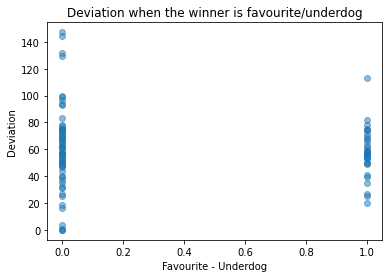

In [15]:
y = df['deviation']
x = df['winner_change']%2

plt.scatter(x, y, alpha=0.5)
plt.title("Deviation when the winner is favourite/underdog")
plt.xlabel("Favourite - Underdog")
plt.ylabel("Deviation")
plt.show()

An underdog will need a minimum amount of deviation to turn the tables which accounts for the lack of points below 20. Also taking all deviation above 80 favourites win 5 to 1, which could be the beginnings of a hypothesis but there's far too little data to tell. But apart from that there is no clear evidence of a pattern.